In [1]:
GPUStats = !nvidia-smi
GPUStats = '\n'.join(GPUStats)
print(GPUStats)

Tue Nov 17 17:09:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Mounted at /content/drive
Getting the images from Google Drive.
Loading images.... This might take a while.
Made list of training image files.
Made list of taining (label) image files.
Made list of test image files.
Made list of test (label) image files.
Creating training images input tensor.
Creating training labels input tensor.
Creating test images input tensor.
Creating test labels input tensor.
Shuffling the training data.
Creating the data set from slices.
Mean squared error between the test images is: 9.059546682692599e-05
Created the datasets from slices.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1600, 2400, 64)    4864      
_________________________________________________________________
re_lu (ReLU)                 (None, 1600, 2400, 64)    0         
_________________________________________________________________
conv2d_1 (Conv

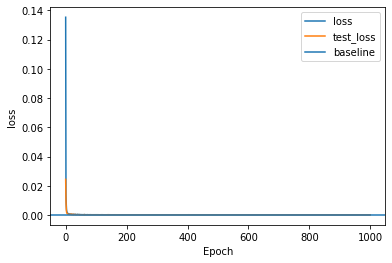

10/10 - 1s - loss: 8.0285e-05 - mean_squared_error: 8.0285e-05
Test loss:8.028488809941337e-05


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import uuid
import os
import datetime

from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras import models, layers, datasets
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from PIL import Image
from numpy import save, asarray
from sklearn.utils import shuffle

import zipfile
from google.colab import drive

drive.mount('/content/drive')

print("Getting the images from Google Drive.")
ZIPData = zipfile.ZipFile(r"/content/drive/My Drive/Images/1280to1600v5.zip", 'r')
ZIPData.extractall("/content/Images/")
ZIPData.close()

print("Loading images.... This might take a while.")

outputResolution = (1600, 2400)
inputShape = (1600,2400,3)
error = 0
preprocessingType = 'gaussian'

def fileToInputTensor(fileList, filepath):
    tempList = []
    for file in fileList:
        inputBytes = tf.io.read_file(filepath + r"/" + file)
        normalizedTensor = tf.cast(tf.image.decode_jpeg(inputBytes, channels=3), tf.float32) / 255 # 3 channels in our photos. Normalize to [0,1] for input.
        resizedinputImageToModel = tf.image.resize(normalizedTensor, size=outputResolution, method=preprocessingType) # This resizes the images to the desired output size.
        numpyArray = np.array(resizedinputImageToModel) # This converts the tensor into a numpy array.
        tempList.append(asarray(numpyArray)) # This appends the array to the list. 
    return tempList

trainingImages = []
trainingLabels = []
testImages = []
testLabels = []

trainingImagesPath = r"/content/Images/Training/lr"
trainingImagesList = os.listdir(trainingImagesPath)
trainingImagesList.sort()
print("Made list of training image files.")

trainingLabelsPath = r"/content/Images/Training/hr/"
trainingLabelsList  = os.listdir(trainingLabelsPath)
trainingLabelsList.sort()
print("Made list of taining (label) image files.")

testImagesPath = r"/content/Images/Test/lr/"
testImagesList = os.listdir(testImagesPath)
testImagesList.sort()
print("Made list of test image files.")

testLabelsPath = r"/content/Images/Test/hr/"
testLabelsList = os.listdir(testLabelsPath)
testLabelsList.sort()
print("Made list of test (label) image files.")

print("Creating training images input tensor.")
trainingImages = fileToInputTensor(trainingImagesList, trainingImagesPath)
print("Creating training labels input tensor.")
trainingLabels = fileToInputTensor(trainingLabelsList, trainingLabelsPath)
print("Creating test images input tensor.")
testImages = fileToInputTensor(testImagesList, testImagesPath)
print("Creating test labels input tensor.")
testLabels = fileToInputTensor(testLabelsList, testLabelsPath)

# Shuffle the training data.
print("Shuffling the training data.")
trainingImages, trainingLabels = shuffle(trainingImages, trainingLabels)

print("Creating the data set from slices.")
trainingDataset = tf.data.Dataset.from_tensor_slices((trainingImages, trainingLabels)).batch(1)
testingDataset = tf.data.Dataset.from_tensor_slices((testImages, testLabels)).batch(1)

# Calculate the average mse for reference.
def calculateOnlyPreprocessing():
  mse = 0
  for x in range(len(testLabels)):
    mse += (np.square(testLabels[x] - testImages[x])).mean(axis=None)
  mse = mse / len(testLabels)
  error = mse
  print("Mean squared error between the test images is: " + str(mse))
  return error
 
error = calculateOnlyPreprocessing()

# Empty the lists that are no longer used.
trainingImages = []
trainingLabels = []
testImages = []
testLabels = []

print("Created the datasets from slices.")
epochs = 1000 # This is based on Colab auto stopping after 24 hours. This can be changed base on epoch time.

# Optimizer
opt = tfa.optimizers.RectifiedAdam(amsgrad=True)
opt = tfa.optimizers.Lookahead(opt)

def create_model():
  # Optimizer
  model = models.Sequential()
  #Patch extraction
  model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), activation=None, use_bias=True, padding="SAME", input_shape=inputShape))
  model.add(layers.ReLU())
  #Non linear mapping.
  model.add(layers.Conv2D(32, (1, 1), strides=(1, 1), activation=None, use_bias=True, padding="SAME"))
  model.add(layers.ReLU())
  # #Non linear mapping. (Repeat)
  # model.add(layers.Conv2D(32, (1, 1), strides=(1, 1), activation=None, use_bias=True, padding="SAME"))
  # model.add(layers.ReLU())
  # #Non linear mapping. (Repeat)
  # model.add(layers.Conv2D(32, (1, 1), strides=(1, 1), activation=None, use_bias=True, padding="SAME"))
  # model.add(layers.ReLU())
  # #Non linear mapping. (Repeat)
  # model.add(layers.Conv2D(32, (1, 1), strides=(1, 1), activation=None, use_bias=True, padding="SAME"))
  # model.add(layers.ReLU())
  # Reconstruction.
  model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), activation=None, use_bias=True, padding="SAME"))
  model.add(layers.ReLU(max_value=1))
  model.compile(optimizer=opt, loss="MeanSquaredError", metrics=['mean_squared_error'])
  return model

# Create the model defined above.
model = create_model()
# Display the model summary.
model.summary()

# Early stopping.
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

history = model.fit(trainingDataset, epochs=epochs, validation_data=(testingDataset), callbacks=[earlyStop])

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.axhline(y = error, label='baseline')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig('figure.pdf')
plt.show()

testLoss, testAccuracy = model.evaluate(testingDataset, verbose=2)
print('Test loss:' + str(testAccuracy))

#The trained network
name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists("/content/drive/My Drive/SavedModels/"):
    os.makedirs("/content/drive/My Drive/SavedModels/")
model.save("/content/drive/My Drive/SavedModels/" + name + '2' +'.h5') 